<h1>Solving Kaggle's Cats vs Dogs with Theano and Lasagne</h1>

The dataset consists of 25k labeled RGB .jpg images of cats and dogs of various resolutions. As a start, I decided to transform the original images into 100 * 100 grayscale images and train a convnet on them. 

The code here relies heavily on the <a href="http://lasagne.readthedocs.org/en/latest/user/tutorial.html#run-the-mnist-example">
lasagne MNIST tutorial</a>.

In [2]:
import sys
import os
import csv
import numpy as np
import Image
import ImageOps
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



# Convert all the image files in the given path into np arrays with dimensions suitable for DL with Theano
def jpg_to_nparray(path, img_size):
    X = []
    Y = []
    counter = 0

    for img_dir in os.listdir(path):

        # X
        img = Image.open(path+img_dir)

        img = ImageOps.fit(img, (img_size, img_size), Image.ANTIALIAS)
        img = ImageOps.grayscale(img)

        # If want to plot some of the images
        #if counter%3000 == 0:
            #imgplot = plt.imshow(img)


        img = np.asarray(img, dtype = 'float32') / 255.
        img = img.reshape(1, img_size, img_size)
        X.append(img)

        # Y: 0 for cat, 1 for dog
        if "cat" in img_dir:
            Y.append(0)
        else:
            Y.append(1)


        # Printing
        counter+=1
        if counter%6000 == 0:
            print'processed images: ', counter

    X = np.asarray(X)
    Y = np.asarray(Y,dtype='int32')

    return (X,Y)



# Get ids of the images: we'll need them for generating the submission file for Kaggle
def get_ids(path):
    ids = np.array([],dtype = int)
    for str in os.listdir(path):
        ids = np.append(ids, int(str.partition(".")[0]))
    
    ids = np.array(ids, dtype = int)[...,None]
    return ids


        
        
def make_datasets(img_size):

    train_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/train/'
    unlabeled_path = '/media/dima/Data/DATA_DL/cats_vs_dogs/test1/'

    print 'Prosessing labeled images'

    X_train, Y_train = jpg_to_nparray(train_path, img_size)

    # Patrtition into labeled training, validatin and test sets
    # Shuffle the examples, because they are in order in the original dataset with all cats being first
    ind = np.arange(25000)
    np.random.seed(1)
    np.random.shuffle(ind)

    X_train = X_train[ind]
    Y_train = Y_train[ind]

    X_val = X_train[0:2999]
    Y_val = Y_train[0:2999]
    X_test = X_train[3000:4999]
    Y_test = Y_train[3000:4999]
    X_train = X_train[5000:24999]
    Y_train = Y_train[5000:24999]

    print 'Prosessing unlabeled images'

    X_unlabeled, Y_unlabeled = jpg_to_nparray(unlabeled_path, img_size)

    pickle.dump((X_train, Y_train, X_val, Y_val, X_test, Y_test, X_unlabeled, Y_unlabeled), 
                open('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets.pkl','wb'))

<h2>Plotting one of the original pictures</h2>


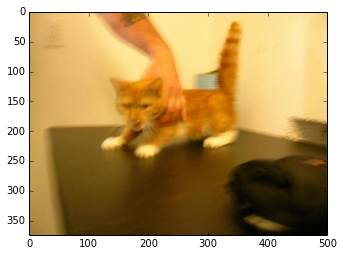

In [6]:
path = ('/media/dima/Data/DATA_DL/cats_vs_dogs/train/')
img = Image.open(path+os.listdir(path)[0])
plt.imshow(img)
plt.show()

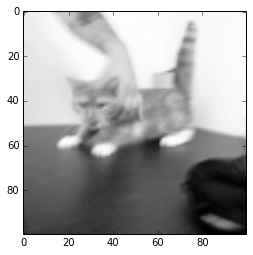

In [7]:
img = ImageOps.fit(img, (100, 100), Image.ANTIALIAS)
img = ImageOps.grayscale(img)
plt.imshow(img, cmap="Greys_r")
plt.show()

In [ ]:
import theano
import theano.tensor as T
import time
import lasagne


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 100, 100),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(7, 7),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    #########
#####################
###############
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    ############
    ############
###############


    ##########
    # One more
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=100, filter_size=(4, 4),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=400,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]




def train_model(num_epochs=30):

    
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test, X_unlabeled, y_unlabeled = pickle.load(
        open(os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/datasets.pkl'),'rb'))

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")


    network = build_cnn(input_var)


    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    l2_regularization = lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2, tags={'regularizable': True})*0.0006
    loss = loss + l2_regularization
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.002, momentum=0.8)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_loss = test_loss + l2_regularization
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates,  allow_input_downcast=True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    get_prediction = theano.function([input_var], [test_prediction])

    
    with np.load('100_grayscale_convnet_NEW_cat_dog_model.npz') as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)


    #Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 250, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
    
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 250, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
    
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        
        # Save weights every 5 epochs
        if (epoch%5 == 0):
            np.savez('100_grayscale_convnet_NEW_cat_dog_model.npz', *lasagne.layers.get_all_param_values(network))



    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 250, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))





    predictions = np.array([],dtype = int)
    # Make predictions
    for batch in iterate_minibatches(X_unlabeled, y_unlabeled, 250, shuffle=False):
        inputs, targets = batch
        batch_predictions = np.array(get_prediction(inputs)).reshape(250,2)
        batch_predictions = batch_predictions[:,1]>batch_predictions[:,0] 
        batch_predictions = np.array(batch_predictions, dtype= int)
        predictions = np.append(predictions, batch_predictions)
    predictions = np.array(predictions, dtype = int)[...,None]
    
    unlabeled_path = os.path.abspath('/media/dima/Data/DATA_DL/cats_vs_dogs/test1/')
    submission_ids = get_ids(unlabeled_path)
    
    submission_array = (np.append(submission_ids, predictions,axis = 1))
    np.savetxt("submission.csv", submission_array,  fmt='%d', delimiter=',', 
               newline='\n', header='id,label', comments = '')
    print("Submission file saved")



    # Save the network weights to a file:
    np.savez('100_grayscale_convnet_NEW_cat_dog_model.npz', *lasagne.layers.get_all_param_values(network))
    # And load them again later on like this:
    with np.load('100_grayscale_convnet_NEW_cat_dog_model.npz') as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)


def visualize():

    #Load network params
    with np.load('100_grayscale_convnet_87_cat_dog_model.npz') as f:
         param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)

if __name__ == '__main__':
    #make_datasets(100)
    train_model()

Loading data...
Building model and compiling functions...
Starting training...

processed images:  5


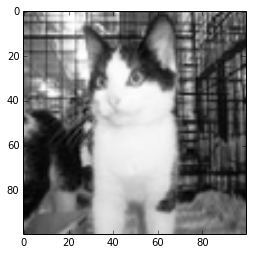

In [23]:
import sys
import os
import time
import csv
import numpy as np
import theano
import theano.tensor as T
import lasagne
import Image
import ImageOps
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


